<a href="https://colab.research.google.com/github/LoPA607/IE643_project/blob/main/ControlNet%2BCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q --upgrade pip

# Install essential HuggingFace stack
!pip install -q diffusers[torch] transformers accelerate huggingface_hub

# Install xformers (GPU-optimized, Colab supports this automatically)
!pip install -q xformers

# Pillow fix for image processing
!pip install -q pillow

# Clean restart to ensure dependencies load correctly
import os, sys
print("✓ All libraries installed without conflict")


In [ ]:
import os

# Change this ONLY IF you have an HF token
os.environ["HUGGINGFACE_HUB_TOKEN"] = "YOUR_HF_TOKEN"

# If you don't have one, leave blank or comment out
print("HF token set (if provided).")


In [ ]:
import torch
from PIL import Image
import numpy as np
import cv2
import os
from pathlib import Path

# Diffusers & transformers
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, UniPCMultistepScheduler
from transformers import CLIPVisionModel, CLIPProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Helper: load image and resize
def load_image(path, size=(512,512)):
    img = Image.open(path).convert("RGB")
    return img.resize(size, Image.LANCZOS)

# Helper: produce 3-channel Canny (PIL)
def make_canny(pil_img, low=100, high=200):
    arr = np.array(pil_img)
    gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, low, high)
    edges3 = np.stack([edges]*3, axis=2)
    return Image.fromarray(edges3)


In [ ]:
print("Loading models (this may take a while)...")

# CLIP vision (for style image embedding)
clip_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# ControlNet (Canny)
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny",
    torch_dtype=torch.float16 if device=="cuda" else torch.float32
)

# Stable Diffusion img2img + ControlNet
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16 if device=="cuda" else torch.float32,
)

# Use UniPC scheduler (good general-purpose scheduler)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# speed/memory opt (optional)
if device == "cuda":
    try:
        pipe.enable_xformers_memory_efficient_attention()
    except Exception as e:
        # xformers may not be supported; continue without it
        print("xformers not enabled:", e)

pipe.to(device)
print("Models loaded and moved to", device)


Saving clean (1).jpg to clean (1) (1).jpg
Uploaded files: ['clean (1) (1).jpg']
Found /content/clean (1).jpg
Found /content/style (1).png


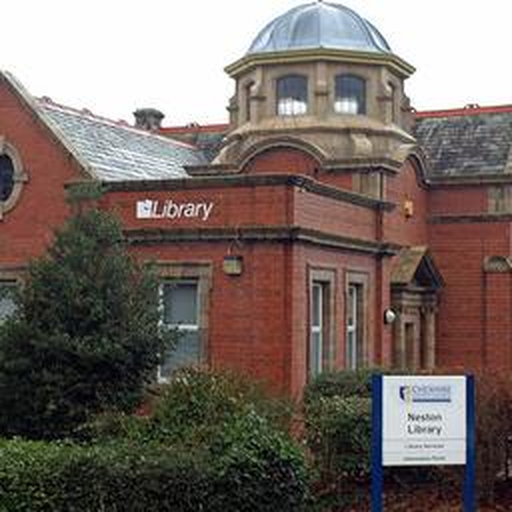

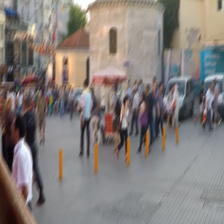

In [ ]:
# Run this cell and use the file picker to upload your images
from google.colab import files
uploaded = files.upload()
print("Uploaded files:", list(uploaded.keys()))

# Now point to your uploaded filenames below (update if different)
CONTENT_PATH = "/content/clean (1).jpg"   # change if your content file has another name
STYLE_PATH   = "/content/style (1).png"     # change if your style file has another name

# Check files exist
for p in [CONTENT_PATH, STYLE_PATH]:
    if not os.path.exists(p):
        print("WARNING: expected", p, "but file not found. Rename or re-upload.")
    else:
        print("Found", p)

# Load and display small preview
content_img = load_image(CONTENT_PATH, size=(512,512))
style_img = load_image(STYLE_PATH, size=(224,224))  # CLIP prefers ~224

display(content_img)
display(style_img)


In [ ]:
print("Extracting CLIP embedding from style image...")
clip_inputs = clip_processor(images=style_img, return_tensors="pt").to(device)

with torch.no_grad():
    clip_out = clip_model(**clip_inputs)
    style_emb = clip_out.pooler_output  # shape (1, dim)
    style_emb = torch.nn.functional.normalize(style_emb, dim=-1)

print("Style embedding shape:", style_emb.shape)


In [ ]:
# Base textual prompt (keeps the generation general / photorealistic)
base_prompt = ""

# Tokenize and get text embeddings from the pipeline's text encoder
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder.to(device)

text_inputs = tokenizer(
    base_prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
).to(device)

with torch.no_grad():
    text_embeds = text_encoder(text_inputs.input_ids)[0]  # (1, seq_len, dim)

# Broadcast style embedding across sequence tokens and add with strength weight
style_strength = 3  # tune in [0.0, 1.0] (higher -> stronger style)
style_broadcast = style_emb.unsqueeze(1).repeat(1, text_embeds.shape[1], 1)
prompt_embeds = text_embeds + style_strength * style_broadcast

print("Prompt embeddings prepared. shape:", prompt_embeds.shape)


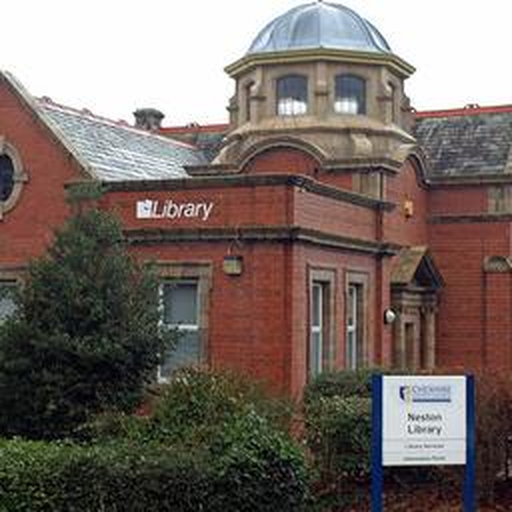

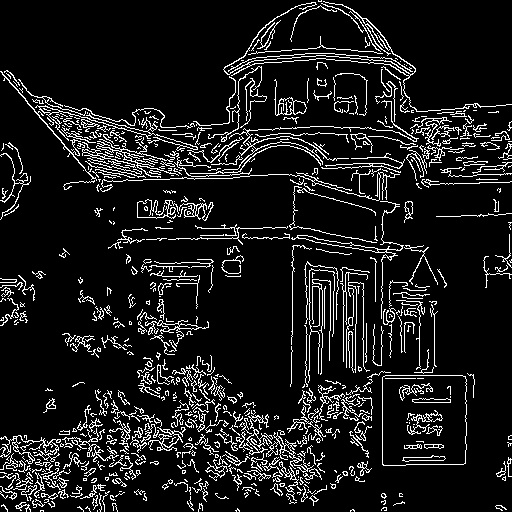

In [ ]:
# Prepare init image (512x512) and canny map
init_image = load_image(CONTENT_PATH, size=(512,512))
control_image = make_canny(init_image, low=100, high=200)

# Show what will be passed to ControlNet
display(init_image)
display(control_image)


In [ ]:
# Inference settings (tune for your trade-off)
num_inference_steps = 50
guidance_scale = 7.5
img2img_strength = 0.9  # lower -> preserves more of content; higher -> more style

generator = torch.Generator(device=device)
generator = generator.manual_seed(42)

print("Running img2img + ControlNet... this may take 30-120s depending on GPU.")
output = pipe(
    prompt_embeds=prompt_embeds,
    image=init_image,
    control_image=control_image,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    strength=img2img_strength,
    generator=generator,
)

result = output.images[0]
out_path = "/content/stylized.png"
result.save(out_path)
print("Saved stylized image to", out_path)
display(result)


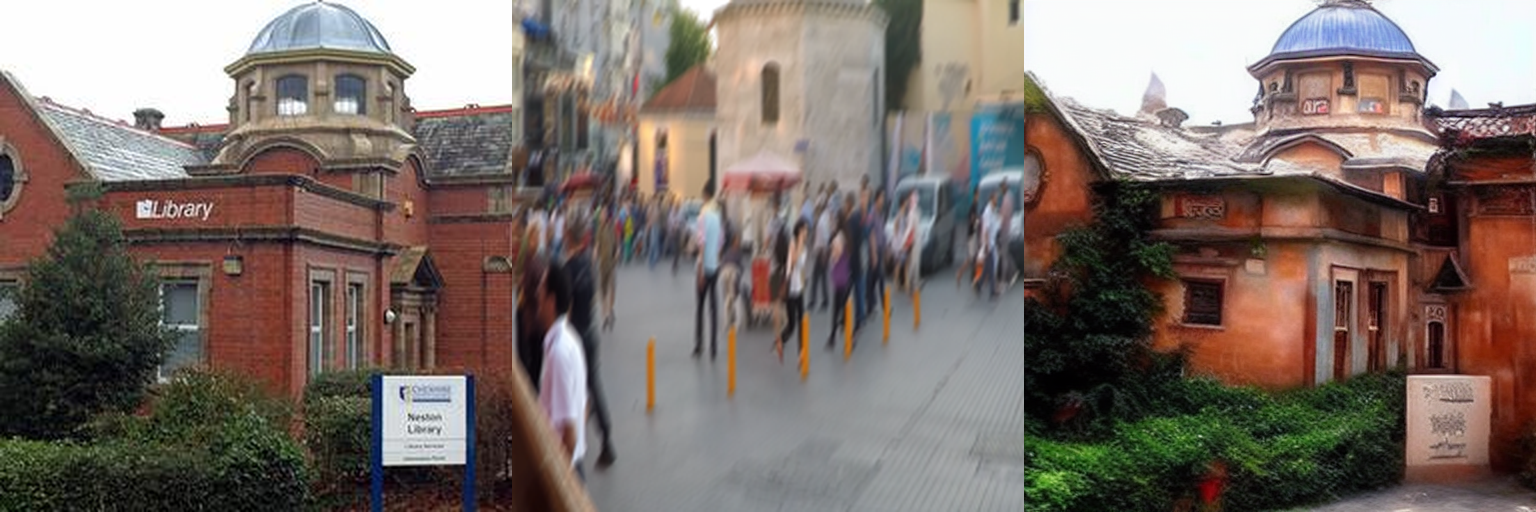

In [ ]:
from PIL import Image

# Get dimensions from the main images (which are 512x512)
width, height = init_image.size

# Resize the style_img to match the content and result images for consistent display
resized_style_img = style_img.resize((width, height), Image.LANCZOS)

# Create a new blank image with enough width for three images and the same height
combined_width = width * 3
combined_image = Image.new('RGB', (combined_width, height))

# Paste images side by side
combined_image.paste(init_image, (0, 0))
combined_image.paste(resized_style_img, (width, 0))
combined_image.paste(result, (width * 2, 0))

display(combined_image)